# 2021-12-08 • Biology vs Izhikevich subthreshold

## [Prelude]

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `lpxtf3` on `DUIP74576` on **Thu 09 Dec** 2021, at 04:19 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1119d931cf1ed9ff93d8a6c72ea030f1df584b9f
) (Tue 07 Dec 2021, 03:59).
Uncommited changes to 10 files.

## $dV/dt$

We reproduce dV curve from Badel 2008, fig 2 B.  
(fig 2 is for cortical neuron, fig 1 for something else).

EIF paremeters are taken from fig 2F, for time since last spike > 200 ms.

In [3]:
E_L = -57 * mV
τ_m = 17 * ms
V_rh = -42 * mV
Δ_T = 1.5 * mV
C = 200 * pF

dV_dt_EIF = lambda V, I: (E_L - V + Δ_T*np.exp((V - V_rh) / Δ_T)) / τ_m + I / C;

Fit Izhikevich neuron to Badel's EIF neuron: same resting potential, same spiking threshold.  
<!-- Parabola's curvature chosen by adapting $R k$ until slope at $E_L$ is the same. -->

In [4]:
from scipy.optimize import newton

In [5]:
V_t = newton(partial(dV_dt_EIF, I=0), -40*mV);

In [6]:
# Rk = 53

k = 0.7 * (nS / mV)

dV_dt_Izh = lambda V, I: (k * (V - E_L) * (V - V_t) + I) / C;

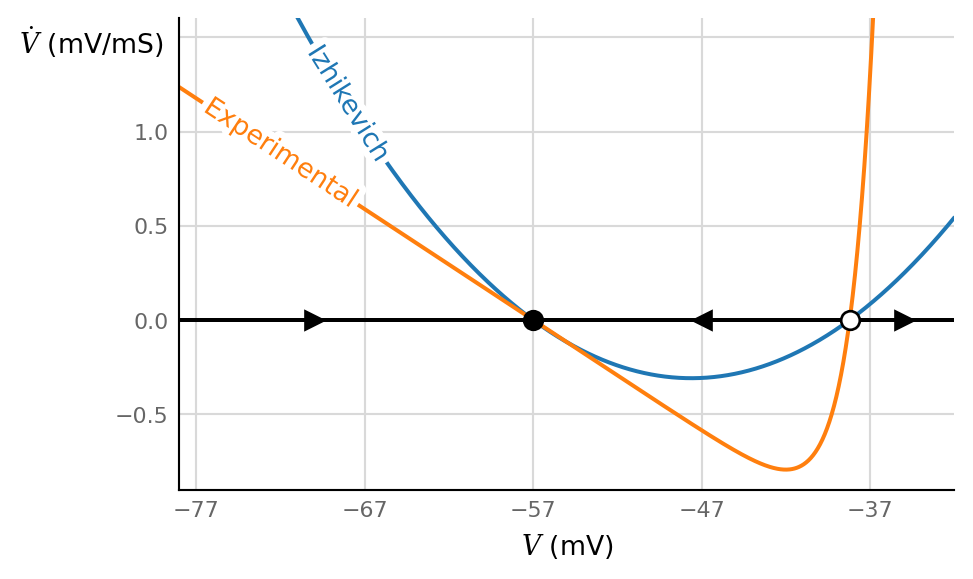

In [7]:
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.set_xlabel("$V$ (mV)")
v.horizontal_ylabel(ax, "$\dot{V}$ (mV/mS)")
V = np.linspace(-78 * mV, -32 * mV, num=1000)
# V = np.linspace(E_L - 0.1*mV, E_L + 0.1*mV, num=1000)
ax.plot(V / mV, dV_dt_Izh(V, I=0), label="Izhikevich")
ax.plot(V / mV, dV_dt_EIF(V, I=0), label="Experimental")
ax.set_xticks(E_L/mV + np.array([-20, -10, 0, 10, 20]))
ax.plot(-70, 0, "k>", ms=7)
ax.plot(-47, 0, "k<", ms=7)
ax.plot(-35, 0, "k>", ms=7)
ax.plot(E_L/mV, 0, "ko", ms=7)
ax.plot(V_t/mV, 0, "ko", ms=7, markerfacecolor="white")
ax.set_xlim(-78, -32)
ax.set_ylim(-0.9, 1.6)
label_lines(ax.lines, xvals=[-68, -72]);

In [69]:
dkw = dict(b=8, c=3)

def f(a, dkw):
    return a,b,c

In [70]:
f(3)

TypeError: f() missing 1 required positional argument: 'dkw'

## Simulation

### Input

In [8]:
from voltage_to_wiring_sim.support.test_current import *

In [54]:
dt = 0.1 * ms
duration = 1700 * ms

timesteps = v.to_indices(duration, dt)

I = np.zeros(timesteps)

Q = 0.22 * nA * 10 * ms

T = 200*ms
τ=10*ms
add_δ(1.7*Q, (t_δ_up := 100*ms), I, dt)
add_δ(-1.7*Q, (t_δ_down := 200*ms), I, dt)
add_pulse_with_decay(Q, 300*ms, T, I, dt, τ)
add_pulse_with_decay(-Q, 450*ms, T, I, dt, τ)
add_pulse_with_decay(2*Q, 600*ms, T, I, dt, τ)
add_pulse_with_decay(-2*Q, 750*ms, T, I, dt, τ)
add_plateau(4*Q, 900*ms, T, I, dt)
add_ramp(4*Q, 1200*ms, T, I, dt)
add_pulse_with_decay(1.1*Q, 1500 * ms, T-100*ms, I, dt)
add_pulse_with_decay(1.1*Q, 1530 * ms, T-100*ms, I, dt)
add_pulse_with_decay(1.1*Q, 1560 * ms, T-100*ms, I, dt)

### Integration

In [55]:
V_EIF = np.ones(timesteps) * E_L
V_Izh = np.ones(timesteps) * E_L

c = 1 * μF/cm**2
A = 20_000 * μm**2
C = c * A

for i in range(timesteps - 1):
    V_EIF[i+1] = V_EIF[i] + dV_dt_EIF(V_EIF[i], I[i]) * dt
    V_Izh[i+1] = V_Izh[i] + dV_dt_Izh(V_Izh[i], I[i]) * dt

### Plot

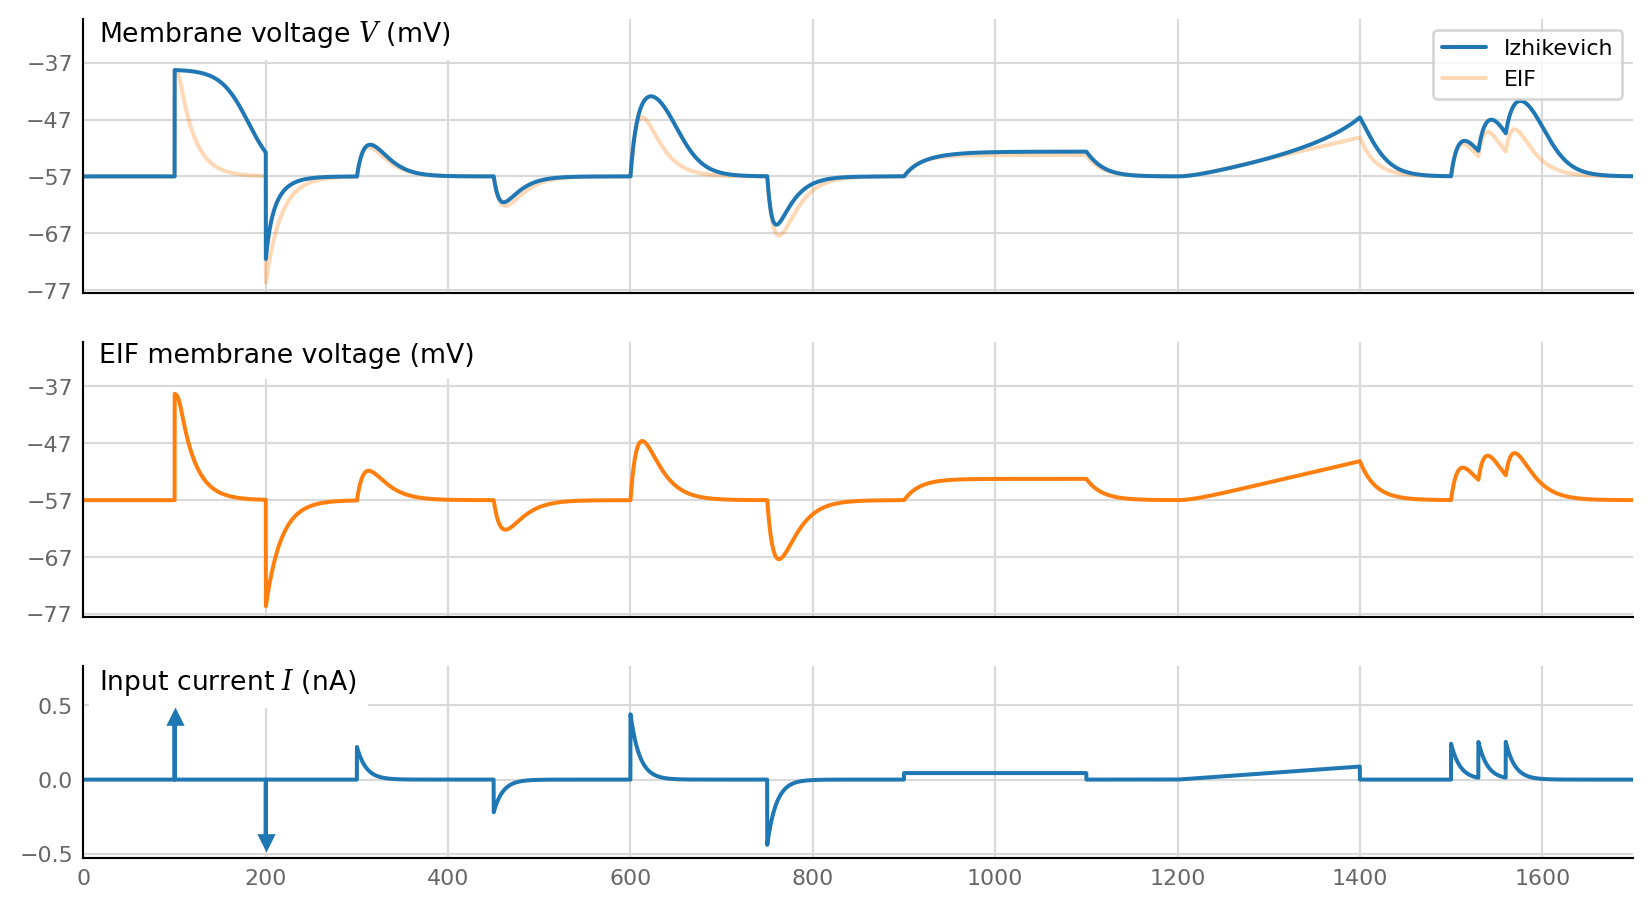

In [66]:
fig, axs = plt.subplots(nrows=3, sharex=True, **v.figsize(aspect=1.8, width=1000),
                         gridspec_kw=dict(height_ratios=[1, 1, 0.7]))

t = np.linspace(0, duration / ms, timesteps, False)
axs[1].plot(t, V_EIF / mV, c="C1")
axs[0].plot(t, V_EIF / mV, c="C1", alpha=0.3, label="EIF")
axs[0].plot(t, V_Izh / mV, c="C0", label="Izhikevich")
v.add_reordered_legend(axs[0], [1,0])
v.ylabel_inside(axs[0], "Membrane voltage $V$ (mV)", ylim_shift=18)
v.ylabel_inside(axs[1], "EIF membrane voltage (mV)", ylim_shift=18)
V_ticks = E_L / mV + np.arange(-20, 21, 10)
axs[0].set_yticks(V_ticks)
axs[1].set_yticks(V_ticks)
axs[1].set_ylim(axs[0].get_ylim())
plot_test_current(axs[2], t, I/nA, (-0.53, 0.53), yδ=0.8)
v.ylabel_inside(axs[2], "Input current $I$ (nA)", ylim_shift=16)
axs[0].set_xlim(left=0, right=duration/ms);

## [Reproducibility]

In [25]:
v.print_reproducibility_info(verbose=True) 

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Tue 07 Dec** 2021, at 02:33 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/07777f4c6e003722f8d60533c3d2f50d9c50d3b0
) (Mon 06 Dec 2021, 20:02).

Uncommited changes to:
```
 M notebooks/2021-12-06__local_HH_dV_shape.ipynb
?? notebooks/2021-11-18__constant_input_spikes.ipynb
?? notebooks/2021-11-18__prototype_new_sim.ipynb
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.9b0             pyhd8ed1ab_1    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brian2                    2.5.0.1          py39h2e07f2f_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
colorful                  0.5.4                    pypi_0    pypi
conda                     4.11.0           py39hcbf5309_0    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
cython                    0.29.24          py39h415ef7b_1    conda-forge
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
gsl                       2.7                  hdfb1a43_0    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
intel-openmp              2021.4.0          h57928b3_3556    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                7.6.5              pyhd8ed1ab_0    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupyterlab_widgets        1.0.2              pyhd8ed1ab_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libblas                   3.9.0              12_win64_mkl    conda-forge
libcblas                  3.9.0              12_win64_mkl    conda-forge
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0              12_win64_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
matplotlib-label-lines    0.4.3                    pypi_0    pypi
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
mkl                       2021.4.0           h0e2418a_729    conda-forge
more-itertools            8.12.0                   pypi_0    pypi
mpmath                    1.2.1              pyhd8ed1ab_0    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
platformdirs              2.3.0              pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prettyprinter             0.18.0                   pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
py-cpuinfo                8.0.0              pyhd8ed1ab_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pympler                   0.9                      pypi_0    pypi
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
regex                     2021.10.23       py39hb82d6ee_1    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
sympy                     1.9              py39hcbf5309_1    conda-forge
tbb                       2021.4.0             h2d74725_1    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tomli                     1.2.2              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typed-ast                 1.4.3            py39hb82d6ee_1    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
widgetsnbextension        3.5.2            py39hcbf5309_1    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```